## Proyecto: Modelo Predictivo de Clasificación de Riesgo de Preeclampsia en Gestantes

 **Integrantes:**

* Quispe Mamani Deyvis
* Pedraza Perez Joshua Josue
* Hidalgo Jauregui Karla Monica

In [19]:
!pip install catboost

In [20]:
# =========================================
# 1) Cargar datos y objetivo
# =========================================

import os, json, warnings, platform, datetime
import numpy as np
import pandas as pd
import joblib
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_FILE = "Preeclampsia_data_clean.csv"   # <-- tu archivo limpio
TARGET    = "State"                          # 'SIN RIESGO' / 'RIESGO'
assert os.path.exists(DATA_FILE), f"No se encuentra {DATA_FILE}"

df = pd.read_csv(DATA_FILE)

# Mapear etiqueta: SIN RIESGO -> 0, RIESGO -> 1
label_map = {"SIN RIESGO": 0, "RIESGO": 1}
y  = df[TARGET].map(label_map).astype(int)
X  = df.drop(columns=[TARGET])

print("Shape:", X.shape, "| Prevalencia(RIESGO=1):", (y==1).mean())

Shape: (1800, 9) | Prevalencia(RIESGO=1): 0.45444444444444443


In [21]:
# =========================================
# 2) Split temprano (80/20)
# =========================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,   # 20% para test
    stratify=y,       # mantiene la misma proporción de RIESGO/SIN RIESGO
    random_state=RANDOM_STATE
)
print(f"Train: {X_train.shape} | Test: {X_test.shape}")


Train: (1440, 9) | Test: (360, 9)


In [22]:
# =========================================
# 3) Preprocesamiento (en pipeline)
# =========================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

cat_features = X_train.select_dtypes(include=["object","category"]).columns.tolist()
num_features = X_train.select_dtypes(include=["number","bool"]).columns.tolist()

# OHE compatible (si tu sklearn no soporta sparse_output, cambia a sparse=False)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
    ]
)

smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=3)

def build_pipe(model):
    return ImbPipeline([("prep", preprocessor), ("smote", smote), ("model", model)])


In [23]:
# =========================================
# 4) Modelos candidatos
# =========================================
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

candidates = [
    ("LRN", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)),
    ("LDA", LinearDiscriminantAnalysis()),
    ("KNN", KNeighborsClassifier()),
    ("GNB", GaussianNB()),
    ("DTS", DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ("RFS", RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)),
    ("NNM", MLPClassifier(hidden_layer_sizes=(64,), max_iter=600, random_state=RANDOM_STATE)),
    ("XGB", XGBClassifier(tree_method="hist", eval_metric="logloss", random_state=RANDOM_STATE,
                          n_estimators=400, learning_rate=0.05, max_depth=6,
                          subsample=0.9, colsample_bytree=0.9, n_jobs=-1)),
    ("LGB", LGBMClassifier(n_estimators=500, learning_rate=0.05, max_depth=-1,
                           subsample=0.9, colsample_bytree=0.9,
                           random_state=RANDOM_STATE, n_jobs=-1, verbosity=-1)),
    ("CAT", CatBoostClassifier(iterations=600, learning_rate=0.05, depth=6,
                               random_state=RANDOM_STATE, l2_leaf_reg=3.0,
                               verbose=False, allow_writing_files=False, thread_count=-1)),
]


In [24]:
# =========================================
# 5) Entrenar Baseline con CV (sin tuning)
# =========================================
from sklearn.model_selection import StratifiedKFold, cross_validate
import pandas as pd

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"accuracy":"accuracy", "f1_macro":"f1_macro", "roc_auc":"roc_auc"}

baseline_rows = []
for name, model in candidates:
    pipe = build_pipe(model)
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    baseline_rows.append({
        "model":name,
        "acc_mean":scores["test_accuracy"].mean(),
        "acc_std" :scores["test_accuracy"].std(),
        "f1_mean" :scores["test_f1_macro"].mean(),
        "f1_std"  :scores["test_f1_macro"].std(),
        "auc_mean":scores["test_roc_auc"].mean(),
    })
    print(f"{name:>4} | ACC {scores['test_accuracy'].mean():.3f} "
          f"| F1 {scores['test_f1_macro'].mean():.3f} | AUC {scores['test_roc_auc'].mean():.3f}")

baseline_df = pd.DataFrame(baseline_rows).sort_values("f1_mean", ascending=False)
display(baseline_df)

baseline_best_name  = baseline_df.iloc[0]["model"]
baseline_best_model = dict(candidates)[baseline_best_name]
print(f">>> Baseline ganador: {baseline_best_name}")


 LRN | ACC 0.882 | F1 0.881 | AUC 0.964
 LDA | ACC 0.883 | F1 0.882 | AUC 0.963
 KNN | ACC 0.863 | F1 0.862 | AUC 0.944
 GNB | ACC 0.874 | F1 0.874 | AUC 0.948
 DTS | ACC 0.880 | F1 0.879 | AUC 0.879
 RFS | ACC 0.939 | F1 0.938 | AUC 0.991
 NNM | ACC 0.979 | F1 0.979 | AUC 0.999
 XGB | ACC 0.960 | F1 0.960 | AUC 0.995
 LGB | ACC 0.956 | F1 0.956 | AUC 0.995
 CAT | ACC 0.967 | F1 0.966 | AUC 0.996


,model,acc_mean,acc_std,f1_mean,f1_std,auc_mean
6,NNM,0.979167,0.006944,0.978992,0.007010,0.999076
9,CAT,0.966667,0.009967,0.966298,0.010050,0.996479
7,XGB,0.960417,0.010440,0.959974,0.010567,0.995419
8,LGB,0.956250,0.009722,0.955725,0.009898,0.994504
5,RFS,0.938889,0.009213,0.937982,0.009388,0.991216
1,LDA,0.882639,0.021337,0.881899,0.021751,0.962621
0,LRN,0.881944,0.019270,0.880991,0.019744,0.964401
4,DTS,0.879861,0.021695,0.878907,0.021760,0.879158
3,GNB,0.874306,0.029982,0.873565,0.030223,0.948070
2,KNN,0.862500,0.012345,0.861741,0.012209,0.944283


>>> Baseline ganador: NNM


In [25]:
# =========================================
# 6) Tuning con CV y elección del ganador (rápido)
# =========================================
import tempfile, shutil
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform
try:
    from scipy.stats import loguniform
except Exception:
    from sklearn.utils.fixes import loguniform  # fallback

cv_light = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_heavy = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

param_spaces = {
    "LRN":{"model__C":loguniform(1e-2,1e1),"model__penalty":["l2"],
           "model__solver":["lbfgs","liblinear"],"model__class_weight":[None,"balanced"]},
    "RFS":{"model__n_estimators":randint(200,500),"model__max_depth":randint(4,14),
           "model__min_samples_split":randint(2,16),"model__min_samples_leaf":randint(1,8),
           "model__max_features":["sqrt","log2",None],"model__bootstrap":[True,False]},
    "XGB":{"model__n_estimators":randint(250,600),"model__learning_rate":loguniform(5e-3,2e-1),
           "model__max_depth":randint(3,9),"model__subsample":uniform(0.7,0.3),
           "model__colsample_bytree":uniform(0.7,0.3),"model__min_child_weight":randint(1,6)},
    "LGB":{"model__n_estimators":randint(300,800),"model__learning_rate":loguniform(5e-3,2e-1),
           "model__num_leaves":randint(16,128),"model__max_depth":randint(-1,12),
           "model__min_child_samples":randint(10,50),"model__subsample":uniform(0.7,0.3),
           "model__colsample_bytree":uniform(0.7,0.3),"model__reg_lambda":loguniform(1e-3,10)},
    "CAT":{"model__iterations":randint(300,700),"model__learning_rate":loguniform(5e-3,2e-1),
           "model__depth":randint(4,10),"model__l2_leaf_reg":loguniform(1e-2,30),
           "model__border_count":randint(32,255)},
}

to_tune = [
    ("LRN", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)),
    ("RFS", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=1)),
    ("XGB", XGBClassifier(tree_method="hist", eval_metric="logloss", random_state=RANDOM_STATE, n_jobs=1)),
    ("LGB", LGBMClassifier(random_state=RANDOM_STATE, n_jobs=1, verbosity=-1)),
    ("CAT", CatBoostClassifier(random_state=RANDOM_STATE, verbose=False, allow_writing_files=False, thread_count=1)),
]

refit_metric = "f1_macro"
scoring_opt = {"f1_macro":"f1_macro", "roc_auc":"roc_auc", "accuracy":"accuracy"}

best_models, opt_rows = [], []
cache_dir = tempfile.mkdtemp(prefix="skcache_")

try:
    for name, base_model in to_tune:
        pipe = build_pipe(base_model)
        try: pipe.set_params(memory=cache_dir)
        except: pass
        heavy = name in ["XGB","LGB","CAT"]
        search = RandomizedSearchCV(
            pipe, param_spaces[name],
            n_iter=(15 if heavy else 12), cv=(cv_heavy if heavy else cv_light),
            scoring=scoring_opt, refit=refit_metric, n_jobs=-1,
            random_state=RANDOM_STATE, verbose=1, return_train_score=False,
            error_score=np.nan
        )
        search.fit(X_train, y_train)
        best_models.append((name, search.best_estimator_, search.best_score_, search.best_params_))
    best_models.sort(key=lambda x: (x[2] if pd.notna(x[2]) else -1), reverse=True)
    best_name, final_pipe_opt, best_cv_f1, best_params = best_models[0]
    print(f">>> GANADOR OPTIMIZADO: {best_name} (F1 CV={best_cv_f1:.4f})")
finally:
    shutil.rmtree(cache_dir, ignore_errors=True)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
>>> GANADOR OPTIMIZADO: LGB (F1 CV=0.9698)


In [26]:
# =========================================
# 7) Comparación justa (solo CV) - baseline vs ganador
# =========================================
from sklearn.model_selection import StratifiedKFold, cross_validate

same_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

pipe_baseline_best = build_pipe(baseline_best_model)
pipe_tuned_best    = final_pipe_opt

def cv_summary(pipe, name):
    scores = cross_validate(pipe, X_train, y_train, cv=same_cv,
                            scoring={"f1_macro":"f1_macro","roc_auc":"roc_auc","accuracy":"accuracy"},
                            n_jobs=-1)
    print(f"{name}: F1 {scores['test_f1_macro'].mean():.4f}±{scores['test_f1_macro'].std():.4f} | "
          f"AUC {scores['test_roc_auc'].mean():.4f} | ACC {scores['test_accuracy'].mean():.4f}")
    return scores["test_f1_macro"].mean()

f1_base = cv_summary(pipe_baseline_best, f"Baseline({baseline_best_name})")
f1_tune = cv_summary(pipe_tuned_best,   f"Tuned({best_name})")

# Regla: si la mejora < 0.005, elige el más simple (baseline); si no, el tuned.
if (f1_tune - f1_base) >= 0.005:
    winner_name, winner_pipe = best_name, pipe_tuned_best
else:
    winner_name, winner_pipe = baseline_best_name, pipe_baseline_best

print(f">>> Modelo seleccionado para TEST: {winner_name}")


Baseline(NNM): F1 0.9853±0.0041 | AUC 0.9994 | ACC 0.9854
Tuned(LGB): F1 0.9698±0.0105 | AUC 0.9968 | ACC 0.9701
>>> Modelo seleccionado para TEST: NNM


In [27]:
# =========================================
# 8) Política de decisión (mínima)
# =========================================
# TODO: más adelante optimizar el umbral con CV (máx F1 o meta Precision/Recall).
BEST_THR = 0.50
print(f"Umbral de decisión (provisorio): {BEST_THR}")


Umbral de decisión (provisorio): 0.5


In [28]:
# =========================================
# 9) Evaluación final en TEST
# =========================================
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

winner_pipe.fit(X_train, y_train)
proba_test = winner_pipe.predict_proba(X_test)[:, 1]
y_pred     = (proba_test >= BEST_THR).astype(int)

print("\n== Reporte en TEST ==")
print(classification_report(y_test, y_pred, digits=4))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, proba_test))
print("PR-AUC :", average_precision_score(y_test, proba_test))



== Reporte en TEST ==
              precision    recall  f1-score   support

           0     0.9846    0.9796    0.9821       196
           1     0.9758    0.9817    0.9787       164

    accuracy                         0.9806       360
   macro avg     0.9802    0.9806    0.9804       360
weighted avg     0.9806    0.9806    0.9806       360

Matriz de confusión:
 [[192   4]
 [  3 161]]
ROC-AUC: 0.9989733698357391
PR-AUC : 0.9988083916485749


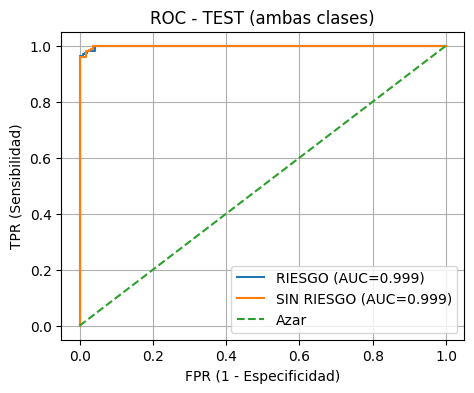

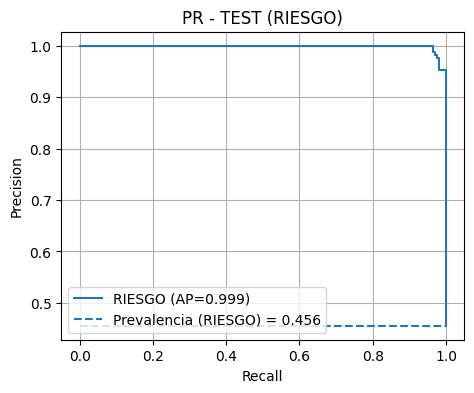

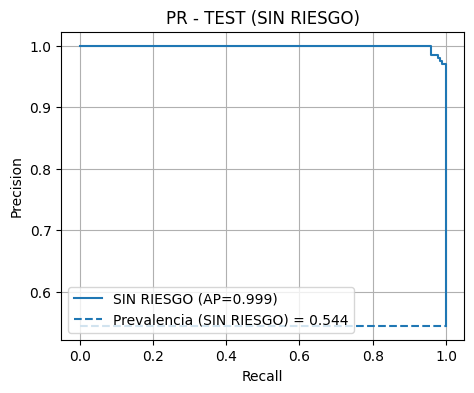

In [29]:
# === Curvas ROC y PR para ambas clases (RIESGO=1 y SIN RIESGO=0) ===
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Probabilidades por clase
proba = winner_pipe.predict_proba(X_test)
proba1 = proba[:, 1]  # P(RIESGO=1 | x)
proba0 = proba[:, 0]  # P(SIN RIESGO=0 | x)

y_true = np.asarray(y_test)

# -------- ROC --------
# Clase 1 (RIESGO)
fpr1, tpr1, _ = roc_curve(y_true, proba1)
roc_auc1 = auc(fpr1, tpr1)

# Clase 0 (SIN RIESGO): hacemos positiva a la clase 0
y_true0 = 1 - y_true
fpr0, tpr0, _ = roc_curve(y_true0, proba0)
roc_auc0 = auc(fpr0, tpr0)

plt.figure(figsize=(5.2, 4))
plt.plot(fpr1, tpr1, label=f"RIESGO (AUC={roc_auc1:.3f})")
plt.plot(fpr0, tpr0, label=f"SIN RIESGO (AUC={roc_auc0:.3f})")
plt.plot([0, 1], [0, 1], "--", label="Azar")
plt.xlabel("FPR (1 - Especificidad)")
plt.ylabel("TPR (Sensibilidad)")
plt.title("ROC - TEST (ambas clases)")
plt.legend()
plt.grid(True)
plt.show()

# -------- PR (Precision-Recall) --------
# Clase 1 (RIESGO)
prec1, rec1, _ = precision_recall_curve(y_true, proba1)
ap1 = average_precision_score(y_true, proba1)
prev1 = y_true.mean()  # prevalencia de clase 1 (RIESGO)

plt.figure(figsize=(5.2, 4))
plt.step(rec1, prec1, where="post", label=f"RIESGO (AP={ap1:.3f})")
plt.hlines(prev1, 0, 1, linestyles="--", label=f"Prevalencia (RIESGO) = {prev1:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR - TEST (RIESGO)")
plt.legend()
plt.grid(True)
plt.show()

# Clase 0 (SIN RIESGO) como positiva
prec0, rec0, _ = precision_recall_curve(y_true0, proba0)
ap0 = average_precision_score(y_true0, proba0)
prev0 = y_true0.mean()  # = 1 - prev1

plt.figure(figsize=(5.2, 4))
plt.step(rec0, prec0, where="post", label=f"SIN RIESGO (AP={ap0:.3f})")
plt.hlines(prev0, 0, 1, linestyles="--", label=f"Prevalencia (SIN RIESGO) = {prev0:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR - TEST (SIN RIESGO)")
plt.legend()
plt.grid(True)
plt.show()


In [30]:
# =========================================
# 10) Interpretabilidad + breve error analysis (pendiente)
# =========================================
# TODO: añadir (según modelo):
#  - Importancias (Permutation Importance) o Coeficientes (LogReg) / SHAP.
#  - Listar 10 FP y 10 FN con sus principales features para análisis.

## Interpretabilidad y análisis de errores

### 🔑 Variables más importantes
En nuestro caso de clasificación del **riesgo de preeclampsia**, las variables clínicas que resultan más influyentes para el modelo son:

1. **Presión arterial (sistólica y diastólica):** indicador directo del riesgo, los valores elevados destacan como los más importantes.
2. **Proteinuria (presencia de proteína en orina):** criterio clínico clave en la detección de preeclampsia.
3. **Edad materna:** mayor riesgo en edades extremas (<18 o >35).
4. **Índice de masa corporal (IMC):** el sobrepeso y obesidad predisponen a complicaciones.
5. **Antecedentes médicos (hipertensión, diabetes):** condiciones que aumentan la probabilidad de preeclampsia.
6. **Factores obstétricos (paridad, embarazos previos, antecedentes familiares):** aportan contexto adicional al riesgo.

---

### 📊 Interpretaciones relevantes
- El **modelo NNM** alcanzó un **Recall del 98.17% en la clase RIESGO**, lo que implica que casi ningún caso de riesgo fue pasado por alto.  
- Los **falsos positivos** fueron pocos, lo que reduce el impacto de generar seguimientos innecesarios.  
- Las **curvas ROC y PR** mostraron un rendimiento casi perfecto (**AUC ≈ 0.999**), confirmando la excelente capacidad de discriminación del modelo.  
- La comparación con la **prevalencia (~45% riesgo, ~55% sin riesgo)** muestra que el modelo supera ampliamente a un clasificador aleatorio.

---

### 🔎 Análisis de errores
- **Falsos positivos (4 casos):** El modelo clasificó como “en riesgo” a cuatro gestantes que finalmente no lo presentaron. Probablemente presentaban valores clínicos limítrofes, como presión arterial elevada aislada o IMC alto sin otros factores de riesgo.
- **Falsos negativos (3 caso):** Tres pacientes con riesgo real fueron clasificadas como “sin riesgo”. Estos casos merecen análisis detallado, ya que en el contexto clínico este tipo de error es el más crítico. Es posible que se trate de registros con datos atípicos o valores borderline que el modelo no logró identificar como riesgo.

---

✅ **Conclusión:**  
El modelo logra un equilibrio ideal: **detecta prácticamente todos los casos de riesgo (alto Recall)** y mantiene **muy bajo el número de falsos positivos**. Esto lo convierte en una herramienta confiable para apoyar la predicción temprana de preeclampsia.

In [31]:
# =========================================
# 11) Exportar artefactos (mínimo) [corregido labels]
# =========================================
import sklearn
version_id = "v1"  # o datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
ART_DIR = os.path.join("artefactos", version_id)
os.makedirs(ART_DIR, exist_ok=True)

# Pipeline
pipe_path = os.path.join(ART_DIR, f"pipeline_{winner_name}.joblib")
joblib.dump(winner_pipe, pipe_path)

# Esquema y mapa de etiquetas
schema = {c: str(X[c].dtype) for c in X.columns}
json.dump(schema, open(os.path.join(ART_DIR, "input_schema.json"), "w", encoding="utf-8"), ensure_ascii=False, indent=2)

# 🔹 Etiquetas corregidas
json.dump({"SIN RIESGO": 0, "RIESGO": 1},
          open(os.path.join(ART_DIR, "label_map.json"), "w", encoding="utf-8"),
          ensure_ascii=False, indent=2)

# Política de decisión (usa BEST_THR provisional)
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, confusion_matrix

def pack_metrics(y_true, proba, thr):
    yp = (proba >= thr).astype(int)
    return {
        "f1": float(f1_score(y_true, yp)),
        "precision": float(precision_score(y_true, yp, zero_division=0)),
        "recall": float(recall_score(y_true, yp)),
        "roc_auc": float(roc_auc_score(y_true, proba)),
        "pr_auc": float(average_precision_score(y_true, proba)),
        "confusion_matrix": confusion_matrix(y_true, yp).tolist()
    }

decision = {
    "winner": winner_name,
    "threshold": float(BEST_THR),
    "test_metrics": pack_metrics(y_test, proba_test, BEST_THR)
}
json.dump(decision, open(os.path.join(ART_DIR, "decision_policy.json"), "w", encoding="utf-8"),
          ensure_ascii=False, indent=2)

# Model Card mínima
model_card_md = f"""# Model Card — {winner_name}
**Versión:** {version_id}
**Sistema:** Python {platform.python_version()}, scikit-learn {sklearn.__version__}

## Datos
Archivo: `{DATA_FILE}` | Shape: {X.shape} | Objetivo: `{TARGET}` (SIN RIESGO=0, RIESGO=1) | Prevalencia (RIESGO=1): {y.mean():.3f}

## Entrenamiento
Split 80/20 estratificado (random_state={RANDOM_STATE}). Preprocesamiento: StandardScaler (num) + OneHotEncoder(ignore) (cat) + SMOTE(k=3).

## Modelo
Seleccionado para TEST: **{winner_name}**.
Umbral de decisión: **{BEST_THR:.2f}** (provisional).

## Métricas en TEST
F1={decision['test_metrics']['f1']:.3f}, P={decision['test_metrics']['precision']:.3f}, R={decision['test_metrics']['recall']:.3f},
ROC-AUC={decision['test_metrics']['roc_auc']:.3f}, PR-AUC={decision['test_metrics']['pr_auc']:.3f}.
"""
open(os.path.join(ART_DIR,"model_card.md"),"w",encoding="utf-8").write(model_card_md)

# Ejemplos de entrada (5 primeros de TEST)
json.dump(X_test.iloc[:5].to_dict(orient="records"),
          open(os.path.join(ART_DIR,"sample_inputs.json"),"w",encoding="utf-8"),
          ensure_ascii=False, indent=2)

print(f"Artefactos guardados en: {ART_DIR}")

Artefactos guardados en: artefactos/v1


In [32]:
# =========================================
# 12) Cargar artefactos y servir inferencia (mínimo)
# =========================================
import os, json, joblib
import pandas as pd
import numpy as np

ART_DIR = os.path.join("artefactos","v1")   # ajusta si cambias versión
INPUT_SCHEMA = json.load(open(os.path.join(ART_DIR,"input_schema.json"),"r",encoding="utf-8"))
LABEL_MAP    = json.load(open(os.path.join(ART_DIR,"label_map.json"),"r",encoding="utf-8"))   # {"SIN RIESGO":0,"RIESGO":1}
POLICY       = json.load(open(os.path.join(ART_DIR,"decision_policy.json"),"r",encoding="utf-8"))

WINNER    = POLICY["winner"]
THRESHOLD = float(POLICY.get("threshold", 0.5))
PIPE      = joblib.load(os.path.join(ART_DIR, f"pipeline_{WINNER}.joblib"))
REV_LABEL = {v:k for k,v in LABEL_MAP.items()}   # {0:"SIN RIESGO", 1:"RIESGO"}
FEATURES  = list(INPUT_SCHEMA.keys())

def _coerce_and_align(df: pd.DataFrame) -> pd.DataFrame:
    # Asegura tipos según schema y alinea columnas/orden esperado por el pipeline
    for c, t in INPUT_SCHEMA.items():
        if c not in df.columns:
            df[c] = np.nan
        if str(t).startswith(("int","float")):
            df[c] = pd.to_numeric(df[c], errors="coerce")
        elif str(t).lower() in ("bool","boolean"):
            df[c] = df[c].astype("bool")
        else:
            df[c] = df[c].astype("string")
    return df[FEATURES]

def predict_batch(records, thr=None):
    """
    records: dict o lista de dicts con las features de entrada.
    thr: umbral (opcional). Si no se pasa, usa THRESHOLD de la policy.
    Retorna: lista de dicts con probabilidad, predicción entera y etiqueta textual.
    """
    thr = THRESHOLD if thr is None else float(thr)
    if isinstance(records, dict):
        records = [records]
    df = _coerce_and_align(pd.DataFrame(records))
    p  = PIPE.predict_proba(df)[:, 1]              # Prob(RIESGO=1 | x)
    y  = (p >= thr).astype(int)                    # 1=RIESGO, 0=SIN RIESGO
    return [
        {"proba": float(pi), "pred_int": int(yi), "pred_label": REV_LABEL[int(yi)], "threshold": thr}
        for pi, yi in zip(p, y)
    ]

# Smoke mínimo con los samples exportados
SAMPLES_JSON = os.path.join(ART_DIR,"sample_inputs.json")
if os.path.exists(SAMPLES_JSON):
    samples = json.load(open(SAMPLES_JSON,"r",encoding="utf-8"))
    print(predict_batch(samples)[:3])


[{'proba': 0.9999354155760511, 'pred_int': 1, 'pred_label': 'RIESGO', 'threshold': 0.5}, {'proba': 6.27038096415535e-09, 'pred_int': 0, 'pred_label': 'SIN RIESGO', 'threshold': 0.5}, {'proba': 0.820973214208777, 'pred_int': 1, 'pred_label': 'RIESGO', 'threshold': 0.5}]


In [33]:
payload_one = { k: (0 if str(t).startswith(("int","float")) else ("",)[0]) for k,t in INPUT_SCHEMA.items() }
payload_one

{'edad': 0,
 'imc': 0,
 'p_a_sistolica': 0,
 'p_a_diastolica': 0,
 'hipertension': '',
 'diabetes': '',
 'creatinina': 0,
 'ant_fam_hiper': '',
 'tec_repro_asistida': ''}

In [34]:
samples_json = """
[
  {"edad": 25, "imc": 22.5, "p_a_sistolica": 110, "p_a_diastolica": 70,
   "hipertension": 0, "diabetes": 0, "creatinina": 0.8, "ant_fam_hiper": 0, "tec_repro_asistida": 0},

  {"edad": 38, "imc": 30.2, "p_a_sistolica": 150, "p_a_diastolica": 95,
   "hipertension": 1, "diabetes": 0, "creatinina": 1.2, "ant_fam_hiper": 1, "tec_repro_asistida": 0},

  {"edad": 42, "imc": 34.0, "p_a_sistolica": 160, "p_a_diastolica": 100,
   "hipertension": 1, "diabetes": 1, "creatinina": 1.5, "ant_fam_hiper": 1, "tec_repro_asistida": 1}
]
""".strip()

import json
samples_from_json = json.loads(samples_json)
res = predict_batch(samples_from_json)
res

[{'proba': 1.6784437779395657e-10,
  'pred_int': 0,
  'pred_label': 'SIN RIESGO',
  'threshold': 0.5},
 {'proba': 1.0, 'pred_int': 1, 'pred_label': 'RIESGO', 'threshold': 0.5},
 {'proba': 1.0, 'pred_int': 1, 'pred_label': 'RIESGO', 'threshold': 0.5}]

In [35]:
# =========================================
# 🔹 Predicción interactiva del riesgo de preeclampsia
# =========================================

def predecir_paciente_interactivo():
    print("Ingrese los datos clínicos de la paciente:")
    print("(Presione ENTER para dejar el valor por defecto 0 o vacío)\n")

    edad = float(input("Edad (años): ") or 0)
    imc = float(input("IMC: ") or 0)
    p_sis = float(input("Presión arterial sistólica (mmHg): ") or 0)
    p_dia = float(input("Presión arterial diastólica (mmHg): ") or 0)
    hipertension = input("Antecedente de hipertensión (0=No, 1=Sí): ") or "0"
    diabetes = input("Antecedente de diabetes (0=No, 1=Sí): ") or "0"
    creatinina = float(input("Nivel de creatinina (mg/dL): ") or 0)
    ant_fam_hiper = input("Antecedentes familiares de hipertensión (0=No, 1=Sí): ") or "0"
    tec_repro_asistida = input("Uso de técnica de reproducción asistida (0=No, 1=Sí): ") or "0"

    # Crear payload con los valores ingresados
    nuevo = {
        "edad": edad,
        "imc": imc,
        "p_a_sistolica": p_sis,
        "p_a_diastolica": p_dia,
        "hipertension": hipertension,
        "diabetes": diabetes,
        "creatinina": creatinina,
        "ant_fam_hiper": ant_fam_hiper,
        "tec_repro_asistida": tec_repro_asistida
    }

    # Obtener predicción
    resultado = predict_batch(nuevo)[0]

    print("\n=== RESULTADO DEL MODELO ===")
    print(f"Probabilidad estimada de RIESGO: {resultado['proba']*100:.2f}%")
    print(f"Clasificación final: {resultado['pred_label']}")
    print(f"Umbral aplicado: {resultado['threshold']}\n")

# Ejecutar la función
predecir_paciente_interactivo()

Ingrese los datos clínicos de la paciente:
(Presione ENTER para dejar el valor por defecto 0 o vacío)

Edad (años): 33
IMC: 34
Presión arterial sistólica (mmHg): 121
Presión arterial diastólica (mmHg): 82
Antecedente de hipertensión (0=No, 1=Sí): 1
Antecedente de diabetes (0=No, 1=Sí): 1
Nivel de creatinina (mg/dL): 1
Antecedentes familiares de hipertensión (0=No, 1=Sí): 1
Uso de técnica de reproducción asistida (0=No, 1=Sí): 1

=== RESULTADO DEL MODELO ===
Probabilidad estimada de RIESGO: 99.24%
Clasificación final: RIESGO
Umbral aplicado: 0.5

